# Available Bluebikes Predictor

My hobby project to predict the number of available bluebikes in 3 stations near my home using historical trip data and weather data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from datetime import datetime
import os
from trip_data import get_data

## Extract and Combine Historical Bluebike Trip Data

Trip data consists of all Bluebike trips from Dec. 2023 to Jan. 2025.

In [2]:
# init data and download trip data csv files

data_path = './trip_data'

# trip data range, currently using 2023 Dec to 2025 Jan
start_year = 2024
end_year = 2025
start_month = 1
end_month = 1
start_date = datetime(start_year, start_month, 1)
end_date = datetime(end_year, end_month, 1)
current_date = start_date

# weather csv filename
weather_csv = f"{start_date.strftime('%Y%m%d')}-{datetime(end_date.year, end_month+1, 1).strftime('%Y%m%d')}-weather-data.csv"

In [108]:
get_data.get_weather_data(start_year, start_month, end_year, end_month+1, data_path)

Downloaded weather data: ./trip_data/20240101-20250201-weather-data.csv


In [6]:
get_data.get_bluebikes_trip_data(start_year,start_month,end_year,end_month,data_path)

https://s3.amazonaws.com/hubway-data/202312-bluebikes-tripdata.zip
Downloading: https://s3.amazonaws.com/hubway-data/202312-bluebikes-tripdata.zip
Downloaded: ./trip_data/202312-bluebikes-tripdata.zip
Extracted: 202312-bluebikes-tripdata.csv to ./trip_data
Deleted zip file: ./trip_data/202312-bluebikes-tripdata.zip
https://s3.amazonaws.com/hubway-data/202401-bluebikes-tripdata.zip
Downloading: https://s3.amazonaws.com/hubway-data/202401-bluebikes-tripdata.zip
Downloaded: ./trip_data/202401-bluebikes-tripdata.zip
Extracted: 202401-bluebikes-tripdata.csv to ./trip_data
Deleted zip file: ./trip_data/202401-bluebikes-tripdata.zip
https://s3.amazonaws.com/hubway-data/202402-bluebikes-tripdata.zip
Downloading: https://s3.amazonaws.com/hubway-data/202402-bluebikes-tripdata.zip
Downloaded: ./trip_data/202402-bluebikes-tripdata.zip
Extracted: 202402-bluebikes-tripdata.csv to ./trip_data
Deleted zip file: ./trip_data/202402-bluebikes-tripdata.zip
https://s3.amazonaws.com/hubway-data/202403-blueb

## Weather Data

In [3]:
weather_df = pd.read_csv(data_path + '/' + weather_csv, skiprows=2)

# rename columns
weather_df = weather_df.rename(columns={
    'temperature_2m (°C)': 'temperature',
    'precipitation (mm)': 'precipitation',
})


# convert time to datetime
weather_df['time'] = pd.to_datetime(weather_df['time'])

# interpolate weather data to 15 min intervals
weather_df_interpolated = weather_df.set_index('time').resample('15min').interpolate()

# reset index
weather_df_interpolated = weather_df_interpolated.reset_index()

# drop Feb 1 2025 data
weather_df_interpolated = weather_df_interpolated[weather_df_interpolated['time'].dt.date != datetime(2025, 2, 1).date()]


weather_df_interpolated

,time,temperature,precipitation
0,2024-01-01 00:00:00,-2.500,0.000
1,2024-01-01 00:15:00,-2.550,0.000
2,2024-01-01 00:30:00,-2.600,0.000
3,2024-01-01 00:45:00,-2.650,0.000
4,2024-01-01 01:00:00,-2.700,0.000
...,...,...,...
38107,2025-01-31 22:45:00,0.675,1.025
38108,2025-01-31 23:00:00,0.600,1.000
38109,2025-01-31 23:15:00,0.575,0.950
38110,2025-01-31 23:30:00,0.550,0.900


Quick Visualization of Weather

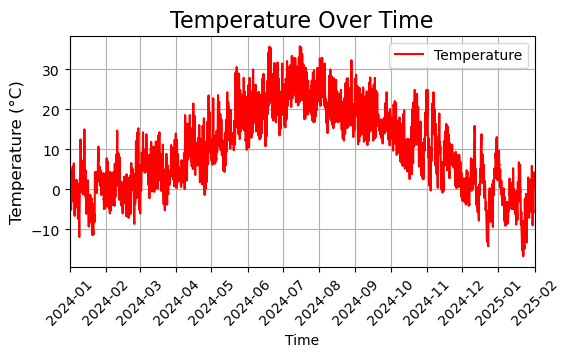

In [4]:
# Plot temperature over time
plt.figure(figsize=(6, 3))
sns.lineplot(x='time', y='temperature', data=weather_df_interpolated, color='red', label='Temperature')
plt.title('Temperature Over Time', fontsize=16)
plt.xlabel('Time', fontsize=10)
plt.ylabel('Temperature (°C)', fontsize=12)
plt.xticks(rotation=45)
plt.xlim(start_date, datetime(end_year, end_month+1,1))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.legend()
plt.grid(visible=True)
plt.show()

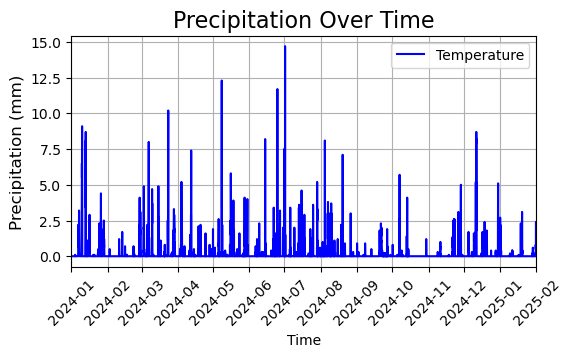

In [5]:
# Plot temperature over time
plt.figure(figsize=(6, 3))
sns.lineplot(x='time', y='precipitation', data=weather_df_interpolated, color='blue', label='Temperature')
plt.title('Precipitation Over Time', fontsize=16)
plt.xlabel('Time', fontsize=10)
plt.ylabel('Precipitation (mm)', fontsize=12)
plt.xticks(rotation=45)
plt.xlim(start_date, datetime(end_year, end_month+1,1))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.legend()
plt.grid(visible=True)
plt.show()

## Trip Data

Load and combine trip CSVs into one dataframe

In [6]:
# combine all trip data into one dataframe
data_frames = []

current_date = start_date

while current_date <= end_date:
    file = f"{current_date.strftime('%Y%m')}-bluebikes-tripdata.csv"
    file_path = os.path.join(data_path, file)
    df = pd.read_csv(file_path)
    data_frames.append(df)

    if current_date.month == 12:
            current_date = datetime(current_date.year + 1, 1, 1)
    else:
        current_date = datetime(current_date.year, current_date.month + 1, 1)

trip_data_df = pd.concat(data_frames, ignore_index=True)

Filter trips to only include stations near my home

In [7]:
# bluebike stations near me
# "A32012" : "Packard's Corner - Commonwealth Ave at Brighton Ave",
# "E32016" : "Commonwealth Ave at Naples Rd",
# "D32035" : "Harvard Ave at Brainerd Rd",
stations_of_interest = ["A32012", "E32016", "D32035"]
stations_docks = {
    "A32012" : 26,
    "E32016" : 19,
    "D32035" : 19
}

# filter trips that start or end at my stations
filtered_trip_data = trip_data_df[trip_data_df['start_station_id'].isin(stations_of_interest) | trip_data_df['end_station_id'].isin(stations_of_interest)].copy()

In [8]:
# remove milliseconds from start and end time
filtered_trip_data.loc[:, 'started_at'] = filtered_trip_data.started_at.str[:16]
filtered_trip_data.loc[:, 'ended_at'] = filtered_trip_data.ended_at.str[:16]

In [9]:
# convert start and end time to datetime
filtered_trip_data['started_at'] = pd.to_datetime(filtered_trip_data.loc[:,'started_at'])
filtered_trip_data['ended_at'] = pd.to_datetime(filtered_trip_data.loc[:,'ended_at'])

# sort by start time
filtered_trip_data.sort_values('started_at', inplace=True)

# remove rideable_type, member_casual columns
filtered_trip_data.drop('rideable_type', axis=1, inplace=True)
filtered_trip_data.drop('member_casual', axis=1, inplace=True)



filtered_trip_data.head()

,ride_id,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng
119455,04CDE2025D36951C,2024-01-01 00:50:00,2024-01-01 01:17:00,Union Square - Somerville,S32002,Harvard Ave at Brainerd Rd,D32035,42.379648,-71.095405,42.349530,-71.130228
96340,A2CACFC2A1914B69,2024-01-01 01:13:00,2024-01-01 01:29:00,Kenmore Square,B32010,Packard's Corner - Commonwealth Ave at Brighto...,A32012,42.348706,-71.097009,42.352261,-71.123831
83237,11CAC8544CB09F8E,2024-01-01 01:14:00,2024-01-01 01:21:00,Old Morse Park at Putnam Ave,M32076,Packard's Corner - Commonwealth Ave at Brighto...,A32012,42.357662,-71.108413,42.352261,-71.123831
47908,18429169FA12A03F,2024-01-01 01:16:00,2024-01-01 01:24:00,Commonwealth Ave at Naples Rd,E32016,MIT Vassar St,M32042,42.351911,-71.123798,42.355601,-71.103945
16161,BD88B024C011CEA5,2024-01-01 01:22:00,2024-01-01 01:25:00,Commonwealth Ave at Kelton St,D32034,Harvard Ave at Brainerd Rd,D32035,42.348359,-71.139972,42.349530,-71.130228


### Aggregate Trip Data

To guess the number of bikes available at a station, I will split the arrivals and departures for each station and round them into intervals.

In [10]:
# dictionary to store results for each station
station_data = {}

sample_interval = '15min'

for station in stations_of_interest:
    # Filter departures and arrivals for the current station
    departures = filtered_trip_data[filtered_trip_data['start_station_id'] == station].copy()
    arrivals = filtered_trip_data[filtered_trip_data['end_station_id'] == station].copy()
    
    # Create a 'time' column for grouping into 15-minute intervals
    departures.rename(columns={'started_at': 'time'}, inplace=True)
    arrivals.rename(columns={'ended_at': 'time'}, inplace=True)
    
    # Resample into 15-minute intervals
    departures_15min = departures.set_index('time').resample(sample_interval).size().rename('departures')
    arrivals_15min = arrivals.set_index('time').resample(sample_interval).size().rename('arrivals')
    
    # Combine departures and arrivals into one DataFrame
    combined = pd.concat([departures_15min, arrivals_15min], axis=1).fillna(0)

    # Create a complete time index from the minimum to the maximum time in the data
    complete_time_index = pd.date_range(
        start=combined.index.min().floor('D'),  # Start at midnight of the first day
        end=combined.index.max().ceil('D') - pd.Timedelta(minutes=15),  # End at 23:45 of the last day
        freq=sample_interval
    )
    
    # Re-index the DataFrame to include all 15-minute intervals
    combined = combined.reindex(complete_time_index, fill_value=0)
    combined = combined.reset_index().rename(columns={'index': 'time'})
    
    # Compute net flow: arrivals - departures
    combined['net_flow'] = combined['arrivals'] - combined['departures']
    
    # Store the combined DataFrame in the dictionary
    station_data[station] = combined

In [11]:
for station, data in station_data.items():
    print(f"Data for station {station}:")
    print(data.iloc[1800:1810])

Data for station A32012:
                    time  departures  arrivals  net_flow
1800 2024-01-19 18:00:00         1.0       3.0       2.0
1801 2024-01-19 18:15:00         1.0       0.0      -1.0
1802 2024-01-19 18:30:00         0.0       1.0       1.0
1803 2024-01-19 18:45:00         1.0       0.0      -1.0
1804 2024-01-19 19:00:00         0.0       3.0       3.0
1805 2024-01-19 19:15:00         1.0       0.0      -1.0
1806 2024-01-19 19:30:00         0.0       1.0       1.0
1807 2024-01-19 19:45:00         0.0       0.0       0.0
1808 2024-01-19 20:00:00         0.0       0.0       0.0
1809 2024-01-19 20:15:00         0.0       1.0       1.0
Data for station E32016:
                    time  departures  arrivals  net_flow
1800 2024-01-19 18:00:00         0.0       0.0       0.0
1801 2024-01-19 18:15:00         0.0       0.0       0.0
1802 2024-01-19 18:30:00         0.0       0.0       0.0
1803 2024-01-19 18:45:00         0.0       3.0       3.0
1804 2024-01-19 19:00:00         0.0  

### Trip Data Inspection

Below I will do some basic trip data inspection, looking through total number of trips per month, net arrivals vs departures per month, hour vs day heatmap, etc.

#### Helper Graphing Functions

In [12]:
def hourly_heatmap(data, station):
    data['hour'] = data.time.dt.hour
    data['day_of_week'] = data.time.dt.day_name()


    numeric_cols = ['departures', 'arrivals', 'net_flow']
    hourly_usage = data.groupby(['day_of_week', 'hour'])[numeric_cols].sum().reset_index()

    # Reorder days of the week for the heatmap
    days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    hourly_usage['day_of_week'] = pd.Categorical(hourly_usage['day_of_week'], categories=days_order, ordered=True)

    departures_hourly_pivot = hourly_usage.pivot(index='day_of_week', columns='hour', values='departures')  # Use 'arrivals' or 'net_flow' if needed
    arrivals_hourly_pivot = hourly_usage.pivot(index='day_of_week', columns='hour', values='arrivals')


    fig, ax = plt.subplots(1, 2, figsize=(18, 6))
    fig.suptitle(f'Hour vs Day of Week Trips for Station {station}')
    sns.heatmap(arrivals_hourly_pivot, cmap="Blues", ax=ax[0], annot=False)
    sns.heatmap(departures_hourly_pivot, cmap="Greens", ax=ax[1], annot=False)
    ax[0].set_title('Arrivals')
    ax[1].set_title('Departures')
    plt.show()

def daily_heatmap(data, station):
    # Add the month name as a feature
    data['month'] = data['time'].dt.month_name()
    data['day_of_week'] = data.time.dt.day_name()
    numeric_cols = ['departures', 'arrivals', 'net_flow']

    # Aggregate data by day of the week and month
    weekly_monthly_usage = data.groupby(['day_of_week', 'month'])[numeric_cols].sum().reset_index()

    # Reorder days of the week for the heatmap
    days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    weekly_monthly_usage['day_of_week'] = pd.Categorical(weekly_monthly_usage['day_of_week'], categories=days_order, ordered=True)

    # Reorder months for the heatmap
    months_order = [
        'January', 'February', 'March', 'April', 'May', 'June',
        'July', 'August', 'September', 'October', 'November', 'December'
    ]
    weekly_monthly_usage['month'] = pd.Categorical(weekly_monthly_usage['month'], categories=months_order, ordered=True)

    # Pivot data for the heatmap
    departure_pivot = weekly_monthly_usage.pivot(index='day_of_week', columns='month', values='departures')  # Use 'arrivals' or 'net_flow' if needed
    arrival_pivot = weekly_monthly_usage.pivot(index='day_of_week', columns='month', values='arrivals')

    fig, ax = plt.subplots(1, 2, figsize=(18, 6))
    fig.suptitle(f'Hour vs Day of Week Trips for Station {station}')
    sns.heatmap(arrival_pivot, cmap="Blues", ax=ax[0], annot=False)
    sns.heatmap(departure_pivot, cmap="Greens", ax=ax[1], annot=False)
    ax[0].set_title('Arrivals')
    ax[1].set_title('Departures')
    plt.show()

def daily_aggregate_chart(data, station):
    data['date'] = data['time'].dt.date
    numeric_cols = ['departures', 'arrivals', 'net_flow']
    # Aggregate daily totals
    daily_usage = data.groupby('date')[numeric_cols].sum().reset_index()

    plt.plot(daily_usage['date'], daily_usage['departures'], label='Departures', color='red')
    plt.plot(daily_usage['date'], daily_usage['arrivals'], label='Arrivals', color='blue')
    # plt.plot(daily_usage['date'], daily_usage['net_flow'], label='Net Flow', color='green', linewidth=2)
    plt.title(f'Trips for Station {station}')
    plt.legend()
    plt.xlabel('Date')
    plt.ylabel('Number of Trips')
    plt.show()

def daily_total_chart(data, station):
    data['date'] = data['time'].dt.date
    numeric_cols = ['departures', 'arrivals', 'net_flow']
    # Aggregate daily totals
    daily_usage = data.groupby('date')[numeric_cols].sum().reset_index()

    plt.plot(daily_usage['date'], daily_usage['departures'] + daily_usage['arrivals'], label='Total Trips', color='purple')
    plt.title(f'Total Trips for Station {station}')
    plt.legend()
    plt.xlabel('Date')
    plt.ylabel('Number of Trips')

def daily_net_flow_chart(data, station):
    data['date'] = data['time'].dt.month
    numeric_cols = ['departures', 'arrivals', 'net_flow']
    # Aggregate daily totals
    daily_usage = data.groupby('date')[numeric_cols].sum().reset_index()

    plt.plot(daily_usage['date'], daily_usage['net_flow'], label='Net Flow', color='green')
    plt.title(f'Net Flow for Station {station}')
    plt.legend()
    plt.xlabel('Date')
    plt.ylabel('Net Flow')
    plt.show()

def monthly_trips_chart(data, station):
    data['month'] = data['time'].dt.to_period('M')
    data['total_trips'] = data['arrivals'] + data['departures']

    monthly_usage = data.groupby('month')[['total_trips', 'net_flow']].sum().reset_index()

    monthly_usage['month'] = monthly_usage['month'].dt.to_timestamp()

    fig, ax = plt.subplots(1,2, figsize=(12, 5))
    ax[0].plot(monthly_usage['month'], monthly_usage['total_trips'], label='Monthyl Total Trips', color='red')
    ax[1].plot(monthly_usage['month'], monthly_usage['net_flow'], label='Monthly Net Flow (Arrivals - Departure)', color='green', linewidth=2)
    # plt.title(f'Monthly Trips for Station {station}')
    ax[0].legend()
    ax[1].legend()
    ax[0].set_title('Monthly Total Trips')
    ax[1].set_title('Monthly Net Flow')
    ax[0].set_xlabel('Month')
    ax[1].set_xlabel('Month')
    ax[0].set_ylabel('Number of Trips')
    ax[1].set_ylabel('Net Flow')
    # plt.xlabel('Month')
    # plt.ylabel('Number of Trips')
    plt.show()

#### Station A32012: Packard's Corner

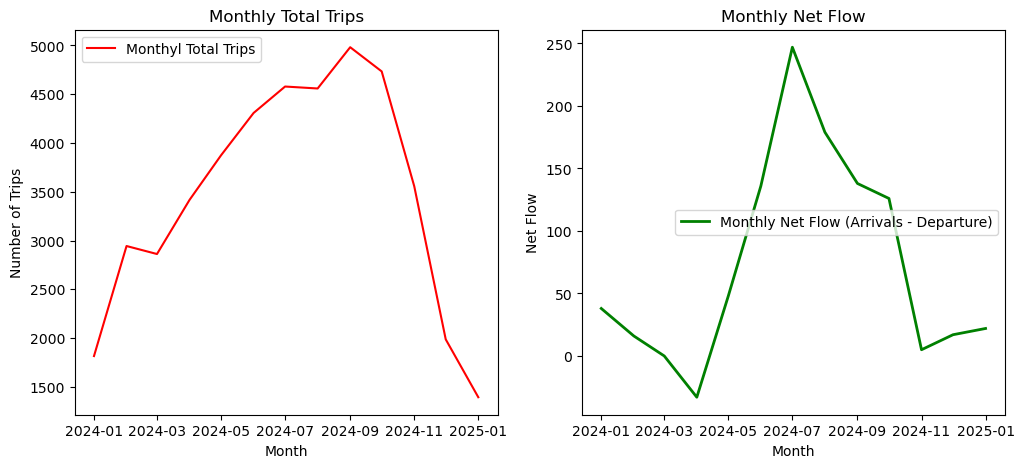

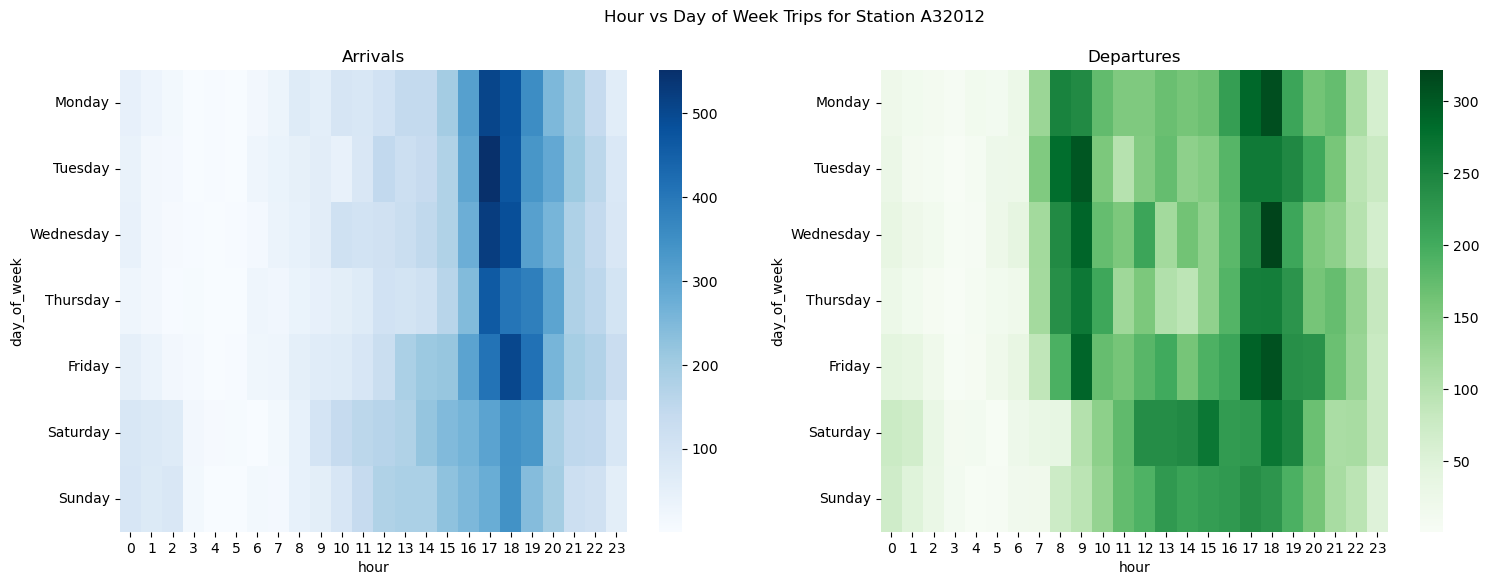

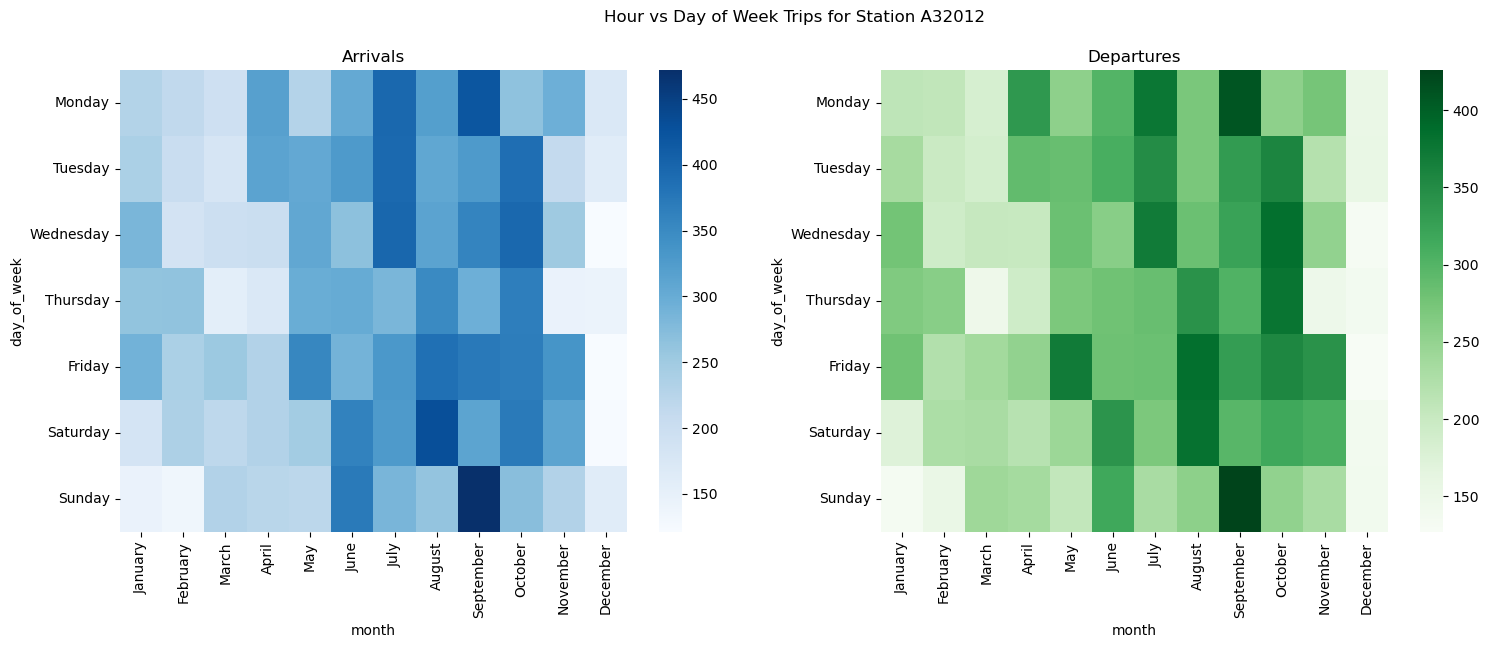

In [21]:
monthly_trips_chart(station_data['A32012'], 'A32012')
hourly_heatmap(station_data['A32012'], 'A32012')
daily_heatmap(station_data['A32012'], 'A32012')

#### Station E32016: Commonwealth Ave Naples Rd.

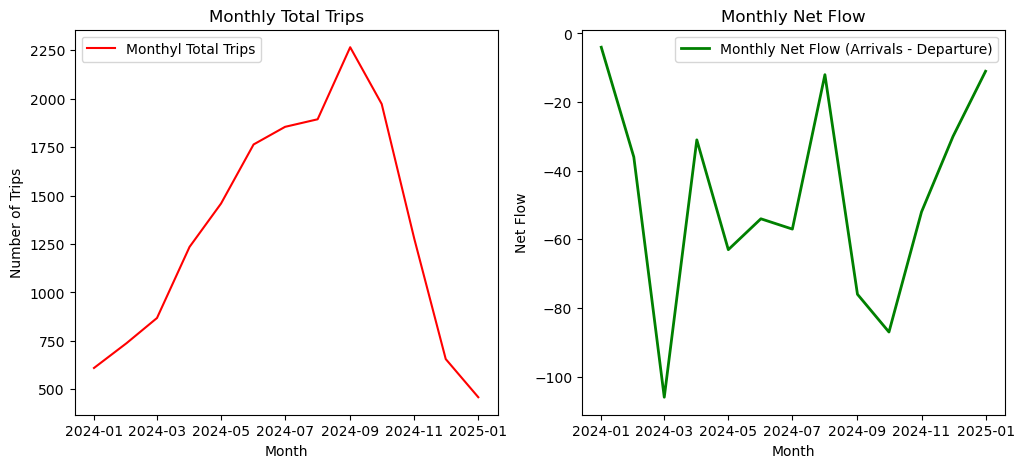

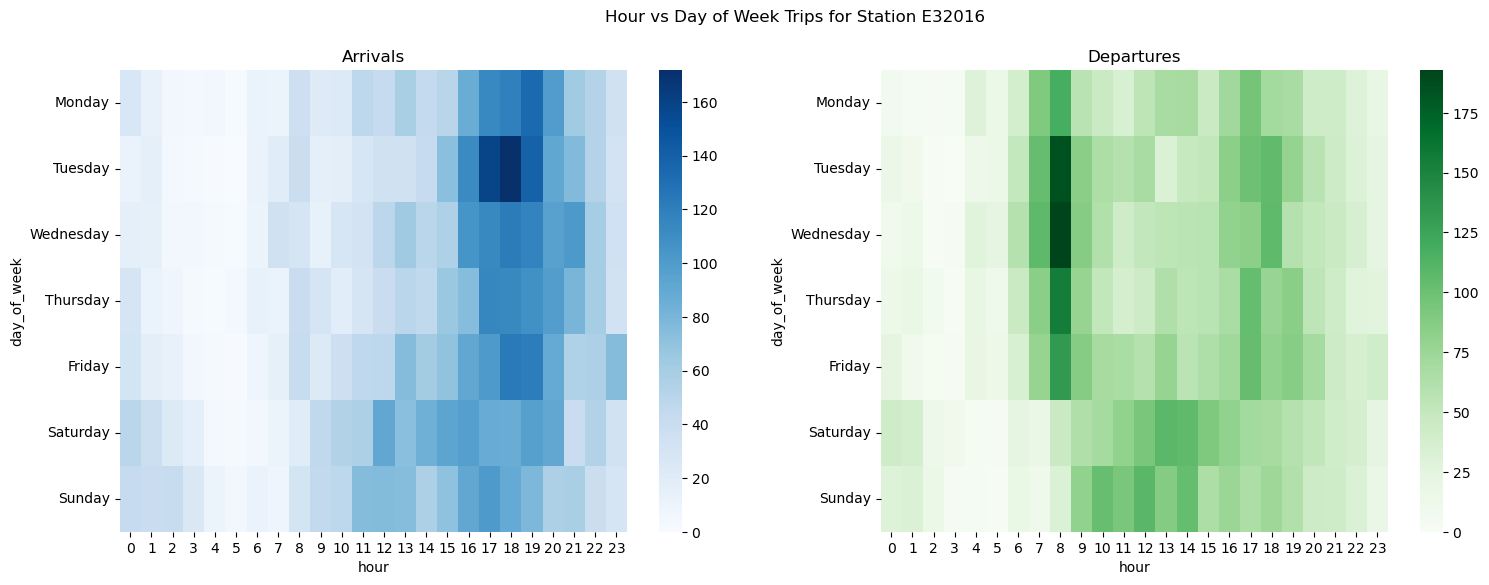

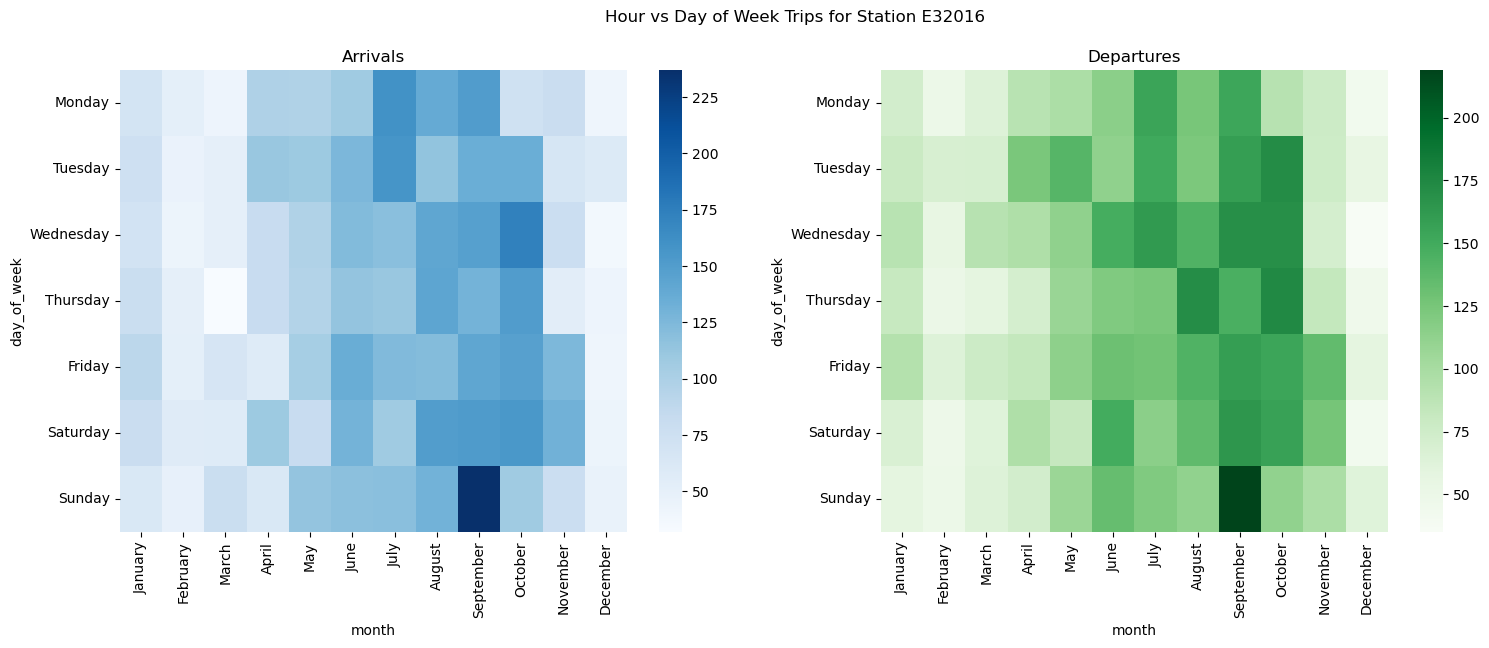

In [22]:
monthly_trips_chart(station_data['E32016'], 'E32016')
hourly_heatmap(station_data['E32016'], 'E32016')
daily_heatmap(station_data['E32016'], 'E32016')

#### Station D32035: Harvard Ave Brainerd Rd

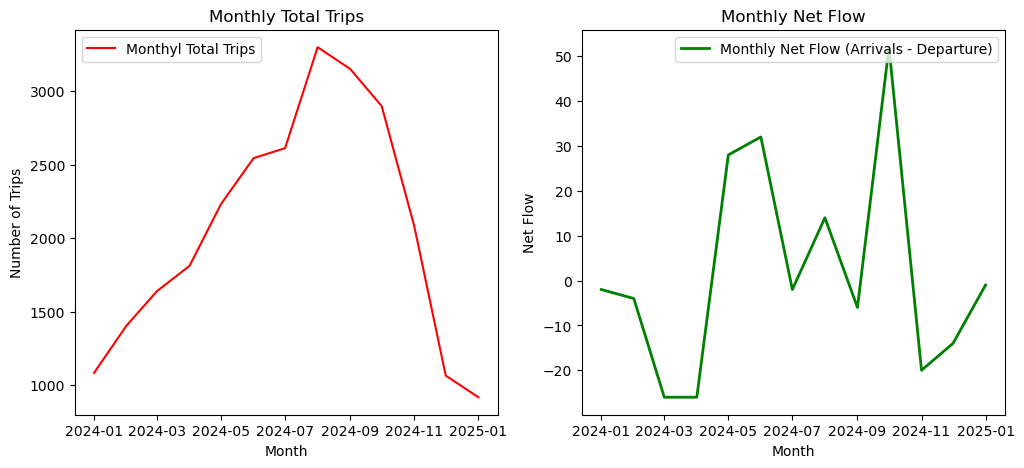

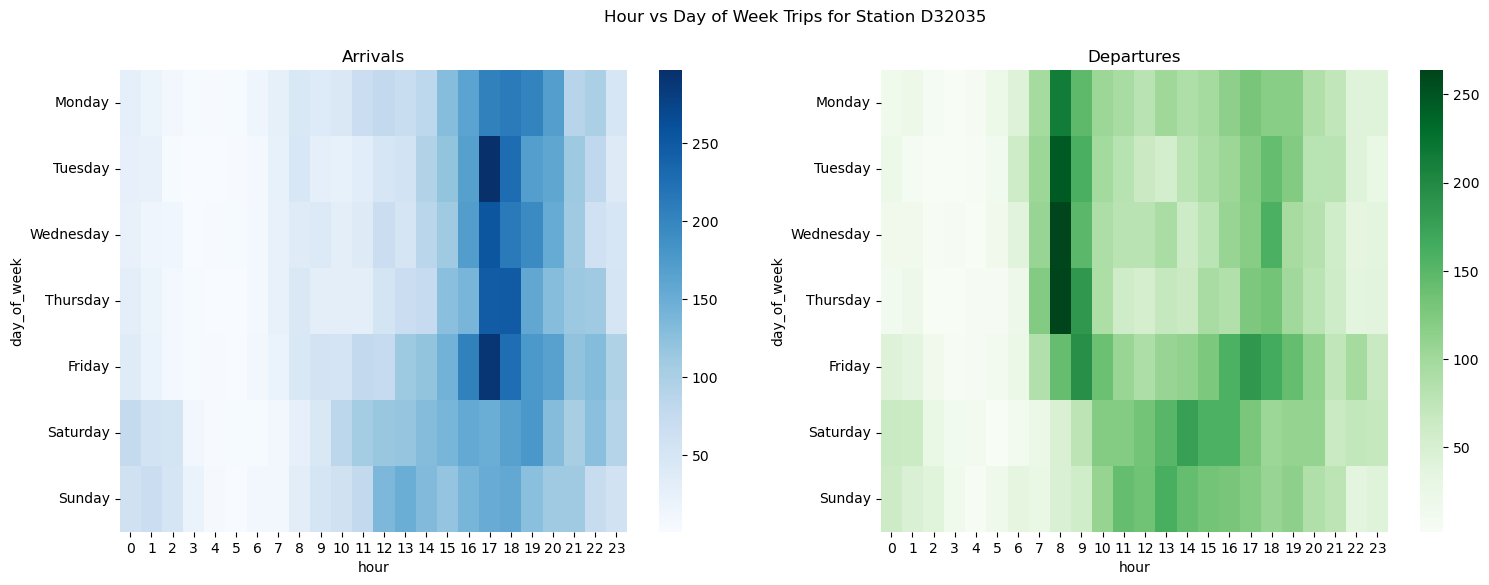

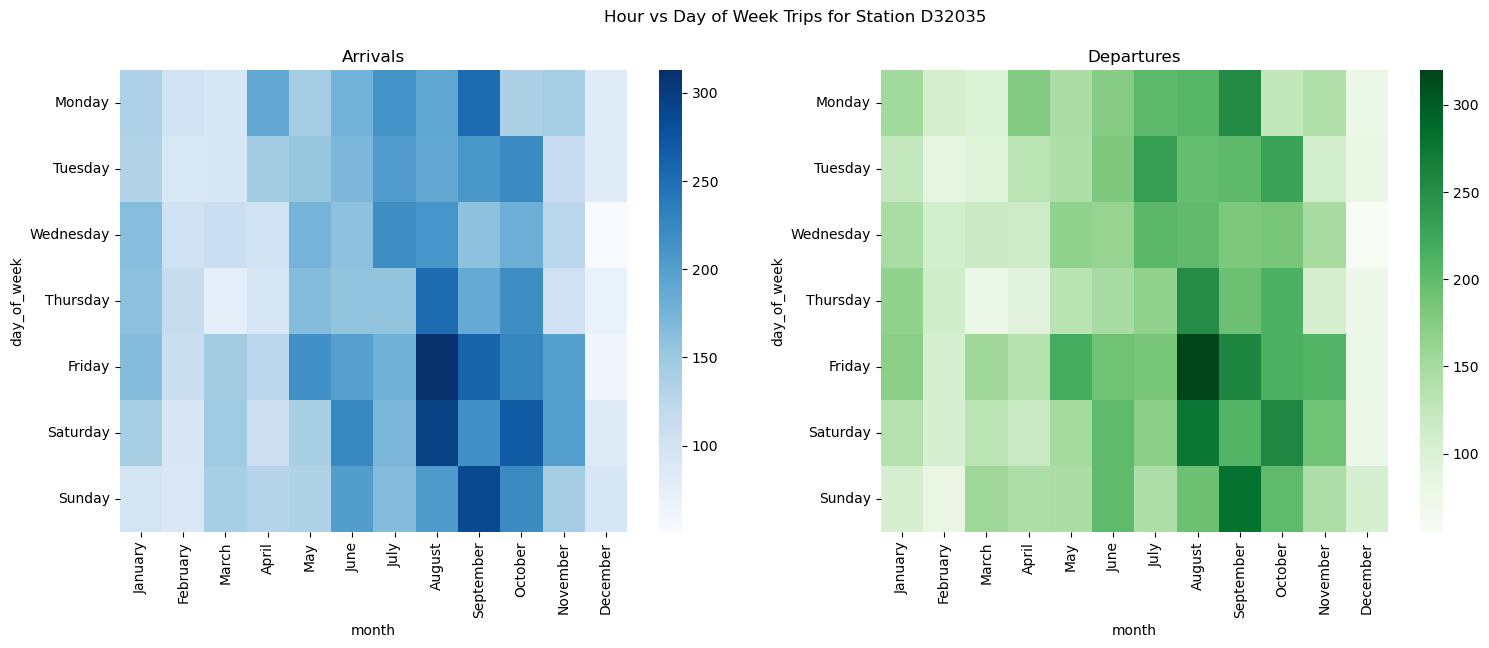

In [23]:
monthly_trips_chart(station_data['D32035'], 'D32035')
hourly_heatmap(station_data['D32035'], 'D32035')
daily_heatmap(station_data['D32035'], 'D32035')

## Trip and Weather Relation

Below I will inspect relationship between number of trips and weather data.

In [30]:
# merge weather data with trip data
merged_data_a32012 = station_data['A32012'].merge(weather_df_interpolated, left_on='time', right_on='time', how='left')

merged_data_a32012

,time,departures,arrivals,net_flow,month,total_trips,hour,day_of_week,temperature,precipitation
0,2024-01-01 00:00:00,0.0,0.0,0.0,January,0.0,0,Monday,-2.500,0.000
1,2024-01-01 00:15:00,0.0,0.0,0.0,January,0.0,0,Monday,-2.550,0.000
2,2024-01-01 00:30:00,0.0,0.0,0.0,January,0.0,0,Monday,-2.600,0.000
3,2024-01-01 00:45:00,0.0,0.0,0.0,January,0.0,0,Monday,-2.650,0.000
4,2024-01-01 01:00:00,0.0,0.0,0.0,January,0.0,1,Monday,-2.700,0.000
...,...,...,...,...,...,...,...,...,...,...
38107,2025-01-31 22:45:00,1.0,0.0,-1.0,January,1.0,22,Friday,0.675,1.025
38108,2025-01-31 23:00:00,1.0,0.0,-1.0,January,1.0,23,Friday,0.600,1.000
38109,2025-01-31 23:15:00,0.0,0.0,0.0,January,0.0,23,Friday,0.575,0.950
38110,2025-01-31 23:30:00,0.0,0.0,0.0,January,0.0,23,Friday,0.550,0.900


In [31]:
def weather_trips_chart(data, station):
    # Convert 'time' to datetime in both DataFrames

    # Plot relationships between total trips and weather variables
    fig, axes = plt.subplots(2, 1, figsize=(10, 12))

    # Scatter plot: Total Trips vs Temperature
    sns.scatterplot(
        data=data,
        x='temperature',
        y='total_trips',
        ax=axes[0],
        color='green',
        # alpha=0.7
    )
    axes[0].set_title('Relationship Between Total Trips and Temperature')
    axes[0].set_xlabel('Temperature (°C)')
    axes[0].set_ylabel('Total Trips')

    # Scatter plot: Total Trips vs Precipitation
    sns.scatterplot(
        data=data,
        x='precipitation',
        y='total_trips',
        ax=axes[1],
        color='blue',
        # alpha=0.7
    )
    axes[1].set_title('Relationship Between Total Trips and Precipitation')
    axes[1].set_xlabel('Precipitation (mm)')
    axes[1].set_ylabel('Total Trips')

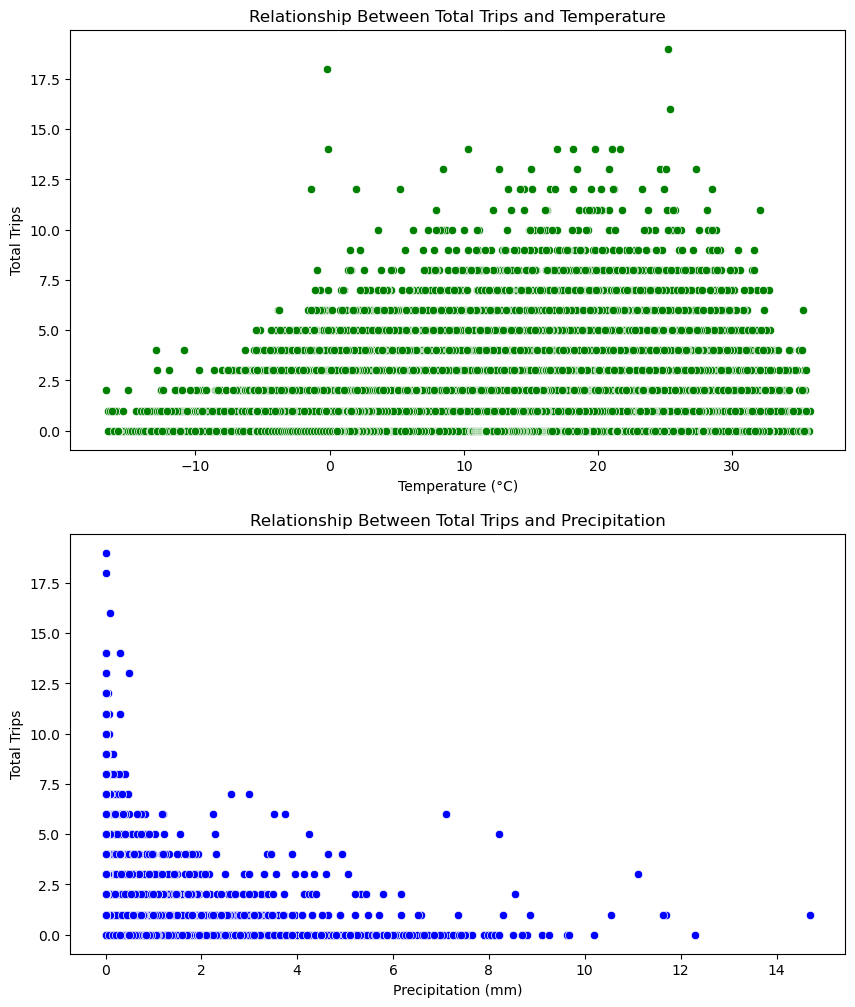

In [32]:
weather_trips_chart(merged_data_a32012, 'A32012')

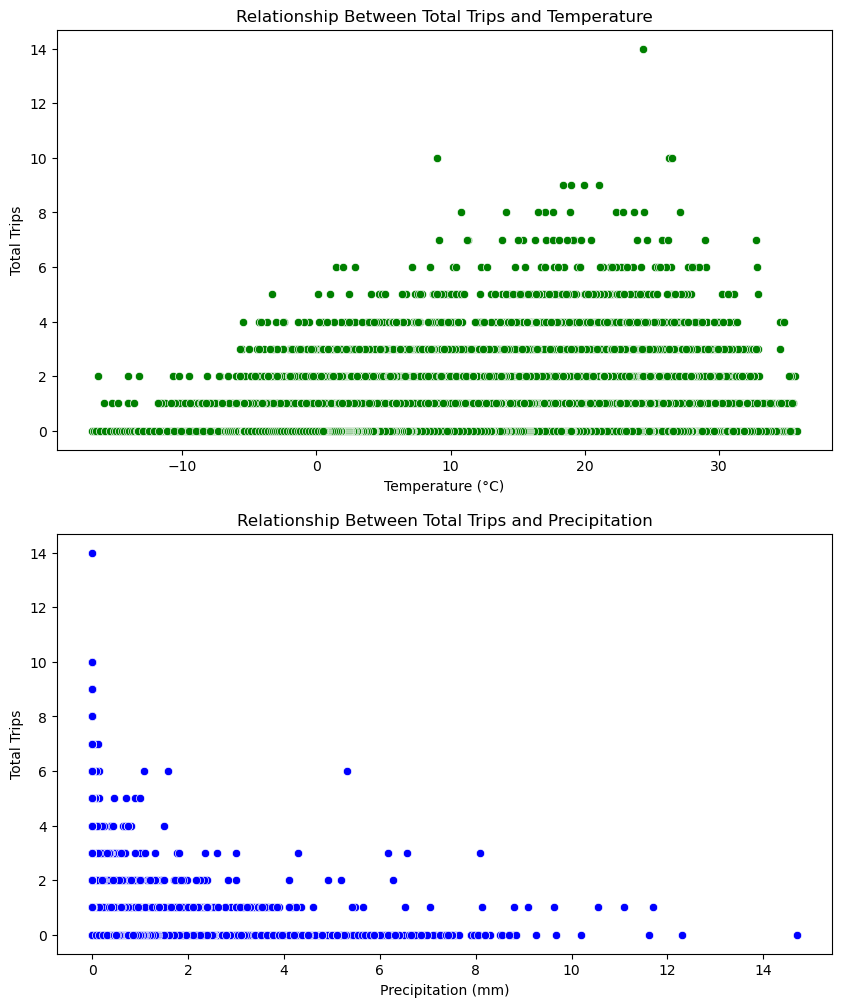

In [33]:
merged_data_e32016 = station_data['E32016'].merge(weather_df_interpolated, left_on='time', right_on='time', how='left')
weather_trips_chart(merged_data_e32016, 'E32016')

## Prediction Model

First, I will try a linear regression model

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score


def weather_trips_regression(data, station):
    X = data[['temperature', 'precipitation']]
    y = data['net_flow']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)